In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import numpy as np

import torch

import matplotlib_config
# import proplot as pplt

import sys
sys.path.append('/global/homes/z/zhantao/Projects/inxs_steering')
from inxss.experiment import NeutronExperiment, SimulatedExperiment

In [2]:
incident_energy = 260
data = torch.load(f'/pscratch/sd/z/zhantao/inxs_steering_production/experiment_data/summarized_neutron_data_w_bkg_{incident_energy:d}meV.pt')

In [3]:
neutron_exp = NeutronExperiment(tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]), data['grid']['w_grid'], data['S'])
hklw_grid = torch.moveaxis(
            torch.stack(torch.meshgrid(neutron_exp.h_grid, neutron_exp.k_grid, neutron_exp.l_grid, neutron_exp.w_grid, indexing='ij'), dim=0), 0, -1)
neutron_exp.prepare_experiment(hklw_grid)

sqw_disp = neutron_exp.Sqw.sum(-1).sum(-1) / (neutron_exp.Sqw > 1).sum(-1).sum(-1)
hk_norm = hklw_grid[...,:2].norm(dim=-1)

In [4]:
q_inner_mid = 1.1441
q_mid_outer = 1.8512

mask_inner = (hk_norm <= q_inner_mid).numpy().sum(-1).sum(-1) > 0
mask_mid = ((hk_norm >  q_inner_mid).numpy() * (hk_norm <=  q_mid_outer).numpy()).sum(-1).sum(-1) > 0
mask_outer = (hk_norm >  q_mid_outer).numpy().sum(-1).sum(-1) > 0

mask_inner = mask_inner.astype('float')
mask_mid = mask_mid.astype('float')
mask_outer = mask_outer.astype('float')

In [5]:
cmap = 'magma'

cmap = sns.color_palette("mako", as_cmap=True)

In [6]:
i_inn, j_inn = np.where(data['background_dict']['inn'] == data['background_dict']['inn'].min())
i_mid, j_mid = np.where(data['background_dict']['mid'] == data['background_dict']['mid'].min())
i_out, j_out = np.where(data['background_dict']['out'] == data['background_dict']['out'].min())
extent = [data['background_dict']['scales'].min(), data['background_dict']['scales'].max(), data['background_dict']['sigmas'].min(), data['background_dict']['sigmas'].max()]

mask_inner[~mask_inner.astype('bool')] = np.nan
mask_mid[~mask_mid.astype('bool')] = np.nan
mask_outer[~mask_outer.astype('bool')] = np.nan

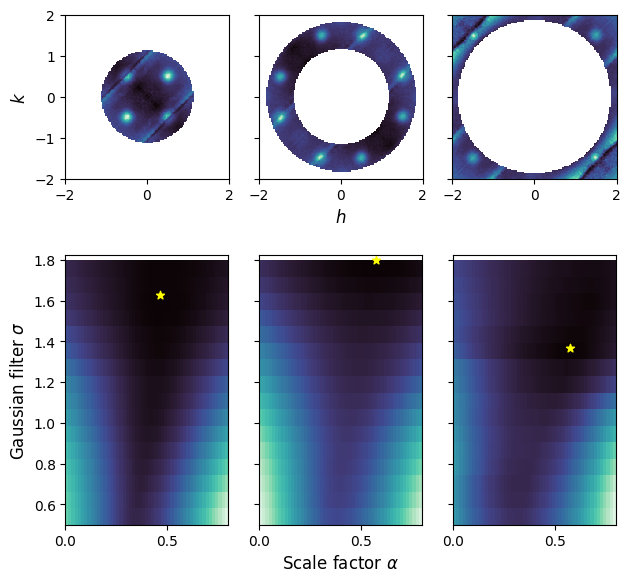

In [7]:
# Assuming 'data', 'extent', 'cmap', 'j_inn', 'i_inn', 'j_mid', 'i_mid', 'j_out', and 'i_out' are defined

# Create a figure with 1 row and 3 columns
# fig, axs = pplt.subplots(nrows=2, ncols=3, figwidth=6.4, sharey=False)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(6.4, 6.4))

axs[0,0].imshow((sqw_disp * mask_inner).T, extent=[-2,2,-2,2], cmap=cmap, origin='lower')
axs[0,1].imshow((sqw_disp * mask_mid).T, extent=[-2,2,-2,2], cmap=cmap, origin='lower')
axs[0,2].imshow((sqw_disp * mask_outer).T, extent=[-2,2,-2,2], cmap=cmap, origin='lower')
axs[0,0].set_ylabel('$k$')
axs[0,1].set_xlabel('$h$')

# First subplot
axs[1,0].imshow(data['background_dict']['inn'], extent=extent, cmap=cmap, origin='lower')
axs[1,0].scatter(data['background_dict']['scales'][j_inn], data['background_dict']['sigmas'][i_inn], c='yellow', marker='*')
axs[1,0].set_ylabel('Gaussian filter $\sigma$')
axs[1,0].set_aspect('equal')

# Second subplot
axs[1,1].imshow(data['background_dict']['mid'], extent=extent, cmap=cmap, origin='lower')
axs[1,1].scatter(data['background_dict']['scales'][j_mid], data['background_dict']['sigmas'][i_mid], c='yellow', marker='*')
axs[1,1].set_xlabel(r'Scale factor $\alpha$')

# Third subplot
axs[1,2].imshow(data['background_dict']['out'], extent=extent, cmap=cmap, origin='lower')
axs[1,2].scatter(data['background_dict']['scales'][j_out], data['background_dict']['sigmas'][i_out], c='yellow', marker='*')

# for _ax in axs:
#     _ax.grid(False)

for i in range(2):
    for j in range(3):
        if i == 1:
            axs[i,j].set_ylim([extent[-2], extent[-1]+0.025])
        if j > 0:
            axs[i,j].set_yticklabels([])

# Adjust layout
fig.tight_layout()
fig.savefig('figures/bkg_subtraction_detail.pdf', bbox_inches='tight')

# Display the figure
fig.show()

In [8]:
q_grid = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Qlist_0.csv', delimiter=',')
w_grid_edges = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Elist_0.csv', delimiter=',')
w_grid = (w_grid_edges[1:] + w_grid_edges[:-1]) / 2

Syy = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Syy_withBroadening_0.csv', delimiter=',')
Szz = np.loadtxt('/pscratch/sd/z/zhantao/inxs_steering/SpinW_data/AFM_data_2023Oct29_NeutronExpParams/Szz_withBroadening_0.csv', delimiter=',')

sim_exp = SimulatedExperiment(q_grid, w_grid, Syy, Szz, neutron_flux=3e2)
s_pred = sim_exp.get_measurements_on_coords(hklw_grid).numpy()

In [9]:
mask_exp = neutron_exp.Sqw > 1e-10
# s_pred_masked = s_pred * mask_exp.cpu().numpy()
# s_pred_disp = s_pred.sum(-1).sum(-1) / (s_pred >  1e-4*s_pred.max()).sum(-1).sum(-1)
mask_pred = (s_pred > 1e-4*s_pred.max()) * mask_exp.cpu().numpy()
s_pred_masked = s_pred * mask_pred

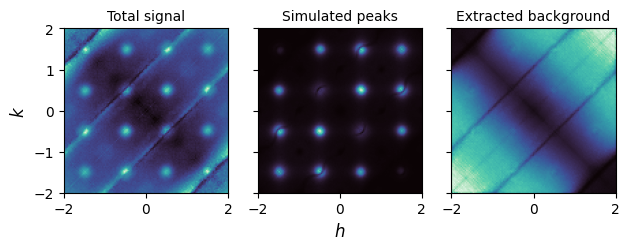

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6.4, 3.2), sharey=True)

axs[0].imshow(sqw_disp.T, extent=[-2,2,-2,2], cmap=cmap, origin='lower')
axs[1].imshow(s_pred_masked.sum(-1).sum(-1).T, extent=[-2,2,-2,2], cmap=cmap, origin='lower')
axs[2].imshow(data['background'].sum(-1).sum(-1).T, extent=[-2,2,-2,2], cmap=cmap, origin='lower')

axs[0].set_ylabel('$k$')
axs[1].set_xlabel('$h$')

axs[0].set_title('Total signal')
axs[1].set_title('Simulated peaks')
axs[2].set_title('Extracted background')

fig.tight_layout()
fig.savefig('figures/bkg_subtraction_summary.pdf', bbox_inches='tight')